# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is October 19**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Csaba Ömböli**  
**Neptun ID: SC3YBP** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [48]:
!pip install opendatasets
!pip install pandas

In [17]:
import pandas
import time
import copy
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools
from torch.utils.data import Dataset

%matplotlib inline
plt.ion() 

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

In [18]:
od.download('https://www.kaggle.com/datasets/moltean/fruits')


In [19]:
from typing import Any, Callable, Optional

class ReducedFolder(datasets.ImageFolder):
    def __init__(self, root: str, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, loader: Callable[[str], Any] = ..., is_valid_file: Optional[Callable[[str], bool]] = None, class_limit = 5):
        
        super().__init__(root = root, transform=transform, target_transform=target_transform, is_valid_file=is_valid_file)
        self.class_limit = class_limit
    
    def find_classes(self, path):
        kept_classes = ['Banana', 'Chestnut', 'Papaya', 'Orange', 'Maracuja']


        classes = sorted(entry.name for entry in os.scandir(path) if entry.is_dir() and entry.name in kept_classes)
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {path}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    

In [20]:

class My_subset(Dataset):
    def __init__(self, dataset, indices,labels):
        self.dataset = dataset
        self.indices = indices
        labels_hold = torch.ones(len(dataset)).type(torch.long) *300 #( some number not present in the #labels just to make sure
        labels_hold[self.indices] = labels 
        self.labels = labels_hold

    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]][0]
        label = self.labels[self.indices[idx]]
        return (image, label)

    def __len__(self):
        return len(self.indices)

In [22]:


MEAN_VALUES = [0.485, 0.456, 0.406]
STD_VALUES = [0.229, 0.224, 0.225]

TRAINING_LIMIT = 2500
TEST_LIMIT = 0

data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_VALUES, STD_VALUES)
    ]),
    'Test': transforms.Compose([
        transforms.Resize(100),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_VALUES, STD_VALUES)
    ]),
}


data_dir = 'content/fruits/fruits-360_dataset/fruits-360'

image_datasets = {x: ReducedFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True,) for x in ['Training', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
class_names = image_datasets['Training'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

print('Dataset loaded')
print(f"Total size: {len(image_datasets['Training']) + len(image_datasets['Test'])} items")
print(f"Number of classes: {len(class_names)}")
print(f"Training-set: {len(image_datasets['Training'])} items")
print(f"Test-set: {dataset_sizes['Test']} items")

['Banana', 'Chestnut', 'Maracuja', 'Orange', 'Papaya']
cuda:0
Dataset loaded
Total size: 3210 items
Number of classes: 5
Training-set: 2401 items
Test-set: 809 items


In [23]:
def plotImage(img, title=None, plot = None):
  img = img.numpy().transpose((1,2,0))
  mean = np.array(MEAN_VALUES)
  std = np.array(STD_VALUES)
  img = std * img + mean
  img = np.clip(img, 0, 1)
  
  if plot != None:
    plot.imshow(img)
  else:
    plt.imshow(img)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated


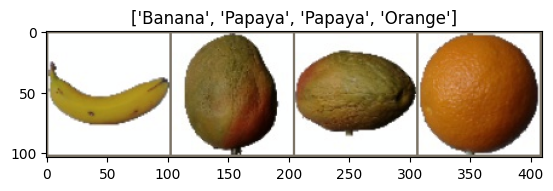

In [24]:
print(iter(dataloaders['Test']))
print(dataloaders['Test'])
inputs, classes = next(iter(dataloaders['Test']))

out = torchvision.utils.make_grid(inputs)

plotImage(out, title=[class_names[x] for x in classes])

#### Splitting the dataset

In [25]:
# ADD YOUR CODE HERE

#### Pre-processing the dataset

In [26]:
# ADD YOUR CODE HERE

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Helper classes and methods

In [27]:

class TrainTracker():
    """Calass to track losses and accuracy while training, and visualize them"""
    def __init__(self) -> None:
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []
    
    def step_train(self, loss, accuracy):
        self.train_loss.append(loss)
        self.train_accuracy.append(accuracy)
    
    def step_test(self, loss, accuracy):
        self.test_loss.append(loss)
        self.test_accuracy.append(accuracy)
    
    def visualize_loss(self):
        train_l = [np.reshape(x, (1)) for x in self.train_loss]
        test_l = [np.reshape(x, (1)) for x in self.test_loss]

        plt.figure(figsize=(6,4))
        plt.title(f'Loss over the epochs ({TRAINING_LIMIT} training images)')
        plt.plot(train_l, label='Training loss')
        plt.plot(test_l, label='Validation loss')
        plt.legend()
        plt.show()

    def visualize_accuracy(self):
        train_a = [np.reshape(x, (1)) for x in self.train_accuracy]
        test_a = [np.reshape(x, (1)) for x in self.test_accuracy]

        plt.figure(figsize=(5,3))
        plt.title(f'Accuracy over the epochs ({TRAINING_LIMIT} training images)')
        plt.plot(train_a, label='Training accuracy')
        plt.plot(test_a, label='Validation accuracy')
        plt.legend()
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        plt.show()

In [28]:
class EarlyStopping():
    """Early-stopping mechanism"""
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0

    def __call__(self, train_loss, validation_loss) -> bool:
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            return self.counter >= self.tolerance
        return False

In [29]:
def visualize_model(model, num_images=6):
    """Generates some predictions with the model, then visualizes it"""
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            labels = labels.cpu()
            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(2,2))
                images_so_far += 1
                ax = plt.subplot(int(np.ceil(num_images/2)), 2, images_so_far)
                ax.axis('off')
                title = 'predicted: {} actual: {}'.format(class_names[preds[j]], class_names[labels[j]])
                plotImage(inputs.cpu().data[j], title, ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Choosing the model, setting up the hyperparameters

In [30]:
# weights are set to be frozen on the CNN, to achive transfer learning
model = models.mobilenet_v2(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

# setting up the final layer of the network
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

C:\Users\Csabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Csabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.0005)

#### Train your network

##### Training one epoch

In [32]:
def train_one_epoch(model, criterion, scheduler, optimizer, tracker):
    # Each epoch has a training and validation phase

        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders['Training']:

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        scheduler.step()

        epoch_loss = running_loss / dataset_sizes['Training']
        epoch_acc = running_corrects.double() / dataset_sizes['Training']

        tracker.step_train(loss=epoch_loss, accuracy=epoch_acc.cpu().detach().numpy())

        print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        return model, criterion, scheduler

##### Validating one epoch

In [33]:
def validate_one_epoch(model, criterion, scheduler, optimizer, tracker, best_acc):
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['Test']:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['Test']
    epoch_acc = running_corrects.double() / dataset_sizes['Test']

    tracker.step_test(loss=epoch_loss, accuracy=epoch_acc.cpu().detach().numpy())

    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # deep copy the model
    if epoch_acc > best_acc:
        best_acc = epoch_acc       
    
    print()
    return model, criterion, scheduler, best_acc

In [34]:
def train_model(model, criterion, optimizer, scheduler, early_stopping ,num_epochs=25):
    since = time.time()
    tracker = TrainTracker()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch, num_epochs - 1, scheduler.get_last_lr()[0]))
        print('-' * 10)

        model, criterion, scheduler = train_one_epoch(model, criterion, scheduler, optimizer, tracker)
        model, criterion, scheduler, new_acc = validate_one_epoch(model, criterion, scheduler, optimizer, tracker, best_acc)
        
        if new_acc > best_acc:
            best_acc = new_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        #early stopping
        if early_stopping(tracker.train_loss[-1], tracker.test_loss[-1]):
            print('Early stopping!')
            break       
        


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tracker

##### Training

In [35]:
PATH = './SC3YBP_net_max.pth'
model, visualizer = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs = 25, early_stopping=EarlyStopping(tolerance=3, min_delta=0.002))
torch.save(model.state_dict(), PATH)

Epoch 0/24 LR 0.000100
----------
Training Loss: 0.9810 Acc: 0.6905
Validation Loss: 0.2937 Acc: 0.9876

Epoch 1/24 LR 0.000100
----------
Training Loss: 0.5744 Acc: 0.8438
Validation Loss: 0.2204 Acc: 0.9963

Epoch 2/24 LR 0.000100
----------
Training Loss: 0.4786 Acc: 0.8563
Validation Loss: 0.0919 Acc: 0.9975

Epoch 3/24 LR 0.000100
----------
Training Loss: 0.4153 Acc: 0.8792
Validation Loss: 0.1259 Acc: 0.9963

Epoch 4/24 LR 0.000100
----------
Training Loss: 0.3993 Acc: 0.8763
Validation Loss: 0.0667 Acc: 1.0000

Epoch 5/24 LR 0.000000
----------
Training Loss: 0.3948 Acc: 0.8667
Validation Loss: 0.0899 Acc: 0.9963

Epoch 6/24 LR 0.000000
----------
Training Loss: 0.4038 Acc: 0.8684
Validation Loss: 0.0736 Acc: 1.0000

Epoch 7/24 LR 0.000000
----------
Training Loss: 0.3902 Acc: 0.8755
Validation Loss: 0.0686 Acc: 0.9988

Epoch 8/24 LR 0.000000
----------
Training Loss: 0.3794 Acc: 0.8796
Validation Loss: 0.0401 Acc: 1.0000

Epoch 9/24 LR 0.000000
----------
Training Loss: 0.3787

#### Results (accuracy and loss) on training and validation sets

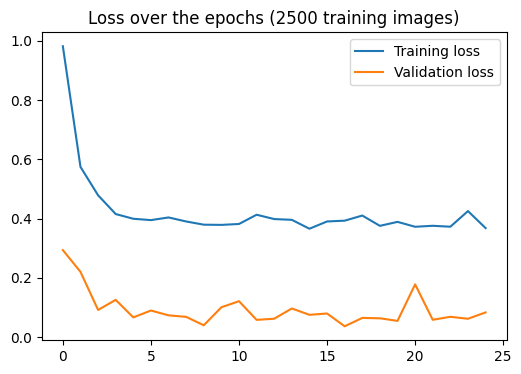

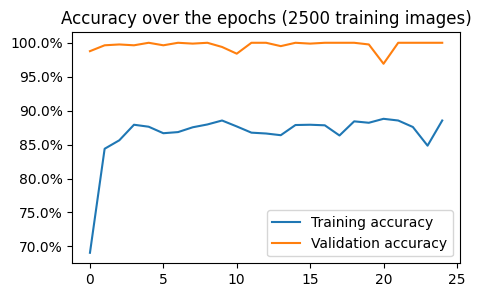

In [36]:
visualizer.visualize_loss()
visualizer.visualize_accuracy()

## 3. Conclusion 



#### Accuracy

In [47]:
running_corrects = 0
for inputs, labels in dataloaders['Test']:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
print('The accuracy on the test set is: ', float(running_corrects.double() / dataset_sizes['Test']))

The accuracy on the test set is:  0.9999999999999999


#### Show some predictions

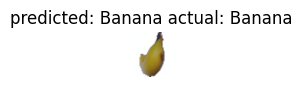

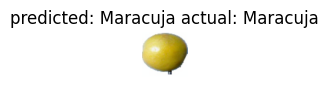

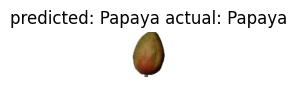

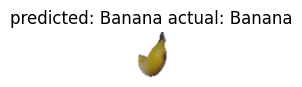

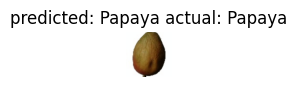

In [41]:
plt.ion()
visualize_model(model, 5)
plt.show()

#### Answer the questions:
* How good are your results? 
* Do you think the network is overfitted or underfitted? 
* If yes, what do you think lead to that? If not, justify.

I think the results show that the model and the training process worked very well. Overfitting is prevented by early stopping, so the ability to generalize remains intact. Since it produces very high accuracy output, I don't think it's underfitting at all.